[View in Colaboratory](https://colab.research.google.com/github/siddharthalodha/mlsid/blob/master/GAN_CelebFaceA.ipynb)

In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [2]:
#@title Default title text
import numpy as np
from keras.preprocessing import image
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,SeparableConv2D
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

!wget https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py
import utils
import os

--2018-05-26 19:25:54--  https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.52.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6935 (6.8K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   6.77K  --.-KB/s    in 0s      

2018-05-26 19:25:54 (59.2 MB/s) - ‘utils.py’ saved [6935/6935]

    100% |████████████████████████████████| 51kB 3.6MB/s 
rm: cannot remove 'tboard.py': No such file or directory
--2018-05-26 19:26:01--  https://raw.githubusercontent.com/mixuala/colab_utils/master/tboard.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.52.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/pla

In [3]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

Found GPU at: /device:GPU:0


In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
l = 20
num_filter =20
compression = 0.6
dropout_rate = 0.2
weight_decay=1e-4

In [5]:
# Load CIFAR10 Data

#http://pjreddie.com/media/files/cifar.tgz
#https://web.archive.org/web/20180521182753/https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

	
# finally converting list into numpy array
x_train = np.array(x_train)
x_test = np.array(x_test)

img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

148643840/170498071 [=========================>....] - ETA: 6s

170500096/170498071 [==============================] - 47s 0us/step


In [0]:
# Dense Block
def add_denseblock(input, num_filter, dropout_rate,l):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same',kernel_regularizer=l2(weight_decay))(relu)

        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
       
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter, dropout_rate):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_regularizer=l2(weight_decay))(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate,l*2)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate,l)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate,l*2)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Fourth_Block = add_denseblock(Third_Transition, num_filter, dropout_rate,l)

output = output_layer(Fourth_Block)


In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 20)   540         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 20)   80          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 20)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
separable_


separable_conv2d_90 (SeparableC (None, 8, 8, 10)     130         separable_conv2d_89[0][0]        
__________________________________________________________________________________________________
dropout_47 (Dropout)            (None, 8, 8, 10)     0           separable_conv2d_90[0][0]        
__________________________________________________________________________________________________
concatenate_45 (Concatenate)    (None, 8, 8, 140)    0           concatenate_44[0][0]             
                                                                 dropout_47[0][0]                 
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 8, 8, 140)    560         concatenate_45[0][0]             
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 8, 8, 140)    0           batch_normalization_48[0][0]     
_________

In [0]:
# determine Loss function and Optimizer
#from utils import GDriveSync
#downloader=GDriveSync()
#filename='DNS_SID_0.8357.h5'
#drive_file_path=downloader.find_items(filename)[0]
#downloader.download_file_to_folder(drive_file_path,filename)
#model.load_weights(filename)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [12]:
from time import time
t0 = time()

def compare(best, new):
  return best.losses['val_acc'] < new.losses['val_acc']

def path(new):
  if new.losses['val_acc'] > 0.8:
    return 'DNS_SID_%s.h5' % new.losses['val_acc']

callbacks = cb = [
      utils.GDriveCheckpointer(compare,path),
      keras.callbacks.TensorBoard(log_dir=os.path.join(utils.LOG_DIR,'DNS_SID'))
]


#model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1,validation_data=(X_test, Y_test),validation_split=0.33, callbacks=callbacks)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test),callbacks=callbacks)

print('Time elapsed: %.2fs' % (time()-t0))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 271s 5ms/step - loss: 1.6947 - acc: 0.3584 - val_loss: 1.6588 - val_acc: 0.4252
Skipping upload because path function returned no path.
Epoch 2/50
16000/50000 [========>.....................] - ETA: 2:39 - loss: 1.3855 - acc: 0.4881

50000/50000 [==============================] - 252s 5ms/step - loss: 1.3090 - acc: 0.5240 - val_loss: 1.2729 - val_acc: 0.5439
Skipping upload because path function returned no path.
Epoch 3/50
35328/50000 [====================>.........] - ETA: 1:08 - loss: 1.1372 - acc: 0.5902

50000/50000 [==============================] - 252s 5ms/step - loss: 1.1261 - acc: 0.5948 - val_loss: 1.1812 - val_acc: 0.5978
Skipping upload because path function returned no path.
Epoch 4/50
41216/50000 [=======================>......] - ETA: 41s - loss: 1.0317 - acc: 0.6308

50000/50000 [==============================] - 252s 5ms/step - loss: 1.0270 - acc: 0.6332 - val_loss: 1.3305 - val_acc: 0.5656
No improvement.
Epoch 5/50
50000/50000 [==============================] - 251s 5ms/step - loss: 0.9661 - acc: 0.6578 - val_loss: 1.4669 - val_acc: 0.5743
No improvement.
Epoch 6/50


50000/50000 [==============================] - 250s 5ms/step - loss: 0.9212 - acc: 0.6729 - val_loss: 1.8483 - val_acc: 0.5187
No improvement.
Epoch 7/50
35712/50000 [====================>.........] - ETA: 1:06 - loss: 0.8911 - acc: 0.6833

50000/50000 [==============================] - 250s 5ms/step - loss: 0.8851 - acc: 0.6856 - val_loss: 0.9628 - val_acc: 0.6755
Skipping upload because path function returned no path.
Epoch 8/50
41344/50000 [=======================>......] - ETA: 40s - loss: 0.8550 - acc: 0.6971

50000/50000 [==============================] - 250s 5ms/step - loss: 0.8518 - acc: 0.6980 - val_loss: 1.0776 - val_acc: 0.6348
No improvement.
Epoch 9/50
50000/50000 [==============================] - 251s 5ms/step - loss: 0.8177 - acc: 0.7145 - val_loss: 1.2061 - val_acc: 0.6325
No improvement.
Epoch 10/50


50000/50000 [==============================] - 251s 5ms/step - loss: 0.7916 - acc: 0.7210 - val_loss: 1.1465 - val_acc: 0.6568
No improvement.
Epoch 11/50
35456/50000 [====================>.........] - ETA: 1:08 - loss: 0.7694 - acc: 0.7321

50000/50000 [==============================] - 252s 5ms/step - loss: 0.7691 - acc: 0.7311 - val_loss: 1.0966 - val_acc: 0.6613
No improvement.
Epoch 12/50
48000/50000 [===========================>..] - ETA: 9s - loss: 0.7375 - acc: 0.7410

50000/50000 [==============================] - 251s 5ms/step - loss: 0.7373 - acc: 0.7409 - val_loss: 1.1098 - val_acc: 0.6505
No improvement.
Epoch 13/50
50000/50000 [==============================] - 251s 5ms/step - loss: 0.7197 - acc: 0.7487 - val_loss: 0.8544 - val_acc: 0.7125
Skipping upload because path function returned no path.
Epoch 14/50
 1152/50000 [..............................] - ETA: 3:49 - loss: 0.6831 - acc: 0.7569

50000/50000 [==============================] - 252s 5ms/step - loss: 0.6977 - acc: 0.7573 - val_loss: 0.8929 - val_acc: 0.7213
Skipping upload because path function returned no path.
Epoch 15/50
30720/50000 [=================>............] - ETA: 1:30 - loss: 0.6773 - acc: 0.7631

50000/50000 [==============================] - 252s 5ms/step - loss: 0.6804 - acc: 0.7630 - val_loss: 0.8844 - val_acc: 0.7162
No improvement.
Epoch 16/50
46336/50000 [==========================>...] - ETA: 17s - loss: 0.6615 - acc: 0.7713

50000/50000 [==============================] - 252s 5ms/step - loss: 0.6606 - acc: 0.7716 - val_loss: 0.7532 - val_acc: 0.7528
Skipping upload because path function returned no path.
Epoch 17/50
44416/50000 [=========================>....] - ETA: 26s - loss: 0.6487 - acc: 0.7748

50000/50000 [==============================] - 252s 5ms/step - loss: 0.6475 - acc: 0.7759 - val_loss: 0.9350 - val_acc: 0.7051
No improvement.
Epoch 18/50
50000/50000 [==============================] - 252s 5ms/step - loss: 0.6296 - acc: 0.7809 - val_loss: 0.8368 - val_acc: 0.7314
No improvement.
Epoch 19/50
  512/50000 [..............................] - ETA: 3:51 - loss: 0.5783 - acc: 0.7891

50000/50000 [==============================] - 252s 5ms/step - loss: 0.6176 - acc: 0.7854 - val_loss: 0.8088 - val_acc: 0.7450
No improvement.
Epoch 20/50
35584/50000 [====================>.........] - ETA: 1:07 - loss: 0.5990 - acc: 0.7924

50000/50000 [==============================] - 252s 5ms/step - loss: 0.5990 - acc: 0.7926 - val_loss: 0.7619 - val_acc: 0.7560
Skipping upload because path function returned no path.
Epoch 21/50
41216/50000 [=======================>......] - ETA: 41s - loss: 0.5921 - acc: 0.7961

50000/50000 [==============================] - 252s 5ms/step - loss: 0.5930 - acc: 0.7965 - val_loss: 0.7270 - val_acc: 0.7691
Skipping upload because path function returned no path.
Epoch 22/50
42880/50000 [========================>.....] - ETA: 33s - loss: 0.5806 - acc: 0.8008

50000/50000 [==============================] - 252s 5ms/step - loss: 0.5808 - acc: 0.8003 - val_loss: 0.7539 - val_acc: 0.7666
No improvement.
Epoch 23/50
50000/50000 [==============================] - 252s 5ms/step - loss: 0.5725 - acc: 0.8025 - val_loss: 0.7656 - val_acc: 0.7574
No improvement.
Epoch 24/50
  256/50000 [..............................] - ETA: 3:55 - loss: 0.5125 - acc: 0.8516

50000/50000 [==============================] - 252s 5ms/step - loss: 0.5590 - acc: 0.8067 - val_loss: 0.8687 - val_acc: 0.7450
No improvement.
Epoch 25/50
35584/50000 [====================>.........] - ETA: 1:07 - loss: 0.5459 - acc: 0.8110

50000/50000 [==============================] - 252s 5ms/step - loss: 0.5507 - acc: 0.8083 - val_loss: 0.6636 - val_acc: 0.7816
Skipping upload because path function returned no path.
Epoch 26/50
41216/50000 [=======================>......] - ETA: 41s - loss: 0.5363 - acc: 0.8142

50000/50000 [==============================] - 252s 5ms/step - loss: 0.5389 - acc: 0.8130 - val_loss: 0.7783 - val_acc: 0.7711
No improvement.
Epoch 27/50
50000/50000 [==============================] - 253s 5ms/step - loss: 0.5302 - acc: 0.8161 - val_loss: 0.8824 - val_acc: 0.7450


No improvement.
Epoch 28/50
50000/50000 [==============================] - 253s 5ms/step - loss: 0.5242 - acc: 0.8216 - val_loss: 0.7778 - val_acc: 0.7638
No improvement.
Epoch 29/50
26496/50000 [==============>...............] - ETA: 1:50 - loss: 0.5144 - acc: 0.8223

50000/50000 [==============================] - 253s 5ms/step - loss: 0.5200 - acc: 0.8206 - val_loss: 0.7683 - val_acc: 0.7678
No improvement.
Epoch 30/50
44928/50000 [=========================>....] - ETA: 23s - loss: 0.5066 - acc: 0.8247

50000/50000 [==============================] - 252s 5ms/step - loss: 0.5080 - acc: 0.8247 - val_loss: 0.6945 - val_acc: 0.7845
Skipping upload because path function returned no path.
Epoch 31/50
44032/50000 [=========================>....] - ETA: 28s - loss: 0.5049 - acc: 0.8264

50000/50000 [==============================] - 252s 5ms/step - loss: 0.5037 - acc: 0.8266 - val_loss: 0.6393 - val_acc: 0.7981
Skipping upload because path function returned no path.
Epoch 32/50
43776/50000 [=========================>....] - ETA: 29s - loss: 0.4883 - acc: 0.8319

50000/50000 [==============================] - 253s 5ms/step - loss: 0.4926 - acc: 0.8306 - val_loss: 1.2066 - val_acc: 0.6839
No improvement.
Epoch 33/50
50000/50000 [==============================] - 253s 5ms/step - loss: 0.4885 - acc: 0.8315 - val_loss: 0.6459 - val_acc: 0.7944
No improvement.
Epoch 34/50
  384/50000 [..............................] - ETA: 3:53 - loss: 0.5059 - acc: 0.8411

50000/50000 [==============================] - 253s 5ms/step - loss: 0.4830 - acc: 0.8332 - val_loss: 0.6475 - val_acc: 0.7927
No improvement.
Epoch 35/50
35584/50000 [====================>.........] - ETA: 1:08 - loss: 0.4766 - acc: 0.8352

50000/50000 [==============================] - 253s 5ms/step - loss: 0.4746 - acc: 0.8364 - val_loss: 0.6864 - val_acc: 0.7936
No improvement.
Epoch 36/50
48128/50000 [===========================>..] - ETA: 8s - loss: 0.4725 - acc: 0.8376

50000/50000 [==============================] - 253s 5ms/step - loss: 0.4726 - acc: 0.8376 - val_loss: 0.7801 - val_acc: 0.7758
No improvement.
Epoch 37/50
50000/50000 [==============================] - 253s 5ms/step - loss: 0.4655 - acc: 0.8410 - val_loss: 0.6911 - val_acc: 0.7897
No improvement.
Epoch 38/50
 1408/50000 [..............................] - ETA: 3:48 - loss: 0.4784 - acc: 0.8381

50000/50000 [==============================] - 253s 5ms/step - loss: 0.4629 - acc: 0.8410 - val_loss: 0.6888 - val_acc: 0.7994
Skipping upload because path function returned no path.
Epoch 39/50
30848/50000 [=================>............] - ETA: 1:30 - loss: 0.4571 - acc: 0.8424

50000/50000 [==============================] - 253s 5ms/step - loss: 0.4614 - acc: 0.8409 - val_loss: 0.7040 - val_acc: 0.7918
No improvement.
Epoch 40/50
46464/50000 [==========================>...] - ETA: 16s - loss: 0.4503 - acc: 0.8435

50000/50000 [==============================] - 252s 5ms/step - loss: 0.4517 - acc: 0.8432 - val_loss: 0.7082 - val_acc: 0.7821
No improvement.
Epoch 41/50
50000/50000 [==============================] - 252s 5ms/step - loss: 0.4493 - acc: 0.8453 - val_loss: 0.9368 - val_acc: 0.7492
No improvement.
Epoch 42/50
 1024/50000 [..............................] - ETA: 3:50 - loss: 0.4091 - acc: 0.8633

50000/50000 [==============================] - 252s 5ms/step - loss: 0.4432 - acc: 0.8484 - val_loss: 0.7840 - val_acc: 0.7820
No improvement.
Epoch 43/50
35840/50000 [====================>.........] - ETA: 1:06 - loss: 0.4345 - acc: 0.8490

50000/50000 [==============================] - 252s 5ms/step - loss: 0.4397 - acc: 0.8473 - val_loss: 0.7427 - val_acc: 0.7849
No improvement.
Epoch 44/50
48256/50000 [===========================>..] - ETA: 8s - loss: 0.4355 - acc: 0.8491

50000/50000 [==============================] - 252s 5ms/step - loss: 0.4355 - acc: 0.8491 - val_loss: 0.7070 - val_acc: 0.7918
No improvement.
Epoch 45/50
50000/50000 [==============================] - 252s 5ms/step - loss: 0.4332 - acc: 0.8498 - val_loss: 0.5968 - val_acc: 0.8205


Uploading file DNS_SID_0.8205.h5 to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 101.94it/s]


Epoch 46/50
50000/50000 [==============================] - 252s 5ms/step - loss: 0.4261 - acc: 0.8524 - val_loss: 0.6284 - val_acc: 0.8126
No improvement.
Epoch 47/50
31360/50000 [=================>............] - ETA: 1:27 - loss: 0.4211 - acc: 0.8578

50000/50000 [==============================] - 252s 5ms/step - loss: 0.4211 - acc: 0.8563 - val_loss: 0.6129 - val_acc: 0.8157
No improvement.
Epoch 48/50
46592/50000 [==========================>...] - ETA: 16s - loss: 0.4125 - acc: 0.8577

50000/50000 [==============================] - 252s 5ms/step - loss: 0.4140 - acc: 0.8569 - val_loss: 0.6906 - val_acc: 0.7990
No improvement.
Epoch 49/50
50000/50000 [==============================] - 252s 5ms/step - loss: 0.4136 - acc: 0.8570 - val_loss: 0.7122 - val_acc: 0.7905
No improvement.
Epoch 50/50
 1024/50000 [..............................] - ETA: 3:50 - loss: 0.3792 - acc: 0.8672

50000/50000 [==============================] - 252s 5ms/step - loss: 0.4105 - acc: 0.8589 - val_loss: 0.7692 - val_acc: 0.7816
No improvement.
Time elapsed: 12713.27s


In [13]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 23s 2ms/step
Test loss: 0.7691524684906006
Test accuracy: 0.7816


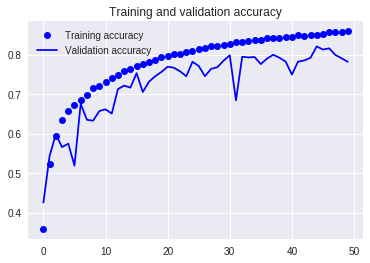

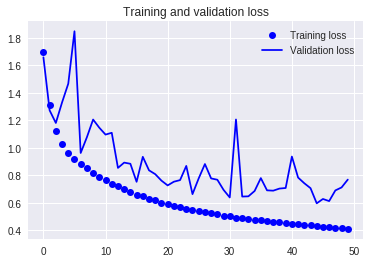

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model.h5')